<b><span style="font-size:150%">Work in progress</span></b>

version August 17th, 2018

# Introduction

This notebook goes through some core machine learning concepts connected to **classification**. It's based on the code in Chapter 3 of the textbook. See also here: https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb

In classification the computer is asked to decide which of N classes an input belongs to. Think of the fishes from the first lecture. Or classifying images according to the objects that appear in the image (i.e. cat vs dogs vs cars, hot dog vs nothotdog).

It's about finding a good function from the inputs $X$ to the a set of labels:

$$f: X \rightarrow \{1, ..., N\}, \qquad \mbox{classification}$$

Classification is one of the two main forms of supervised learning. The other one is **regression**, which is about finding a function that maps from the inputs to a continuous set of numbers. Think of the housing prices from Assignment 1. 

$$f: X \rightarrow \mathbb{R}, \qquad \mbox{regression}$$

How do you decide whether you have a classification or a regression problem? Ask yourself
> Is there continuity in the possible predicitons?

Predicting a price of 1.500.000 versus 1.500.001 makes a small difference and you should probably treat this as a regression problem. Predicting that something contains object #12 versus object #13 likely makes a huge difference, which suggests that you're dealing with a classification problem.

# Setup

In [1]:
# To suppress some warnings below. Nothing important, just to make some outputs cleaner.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

As usual, we add the following cell:

In [2]:
# To automatically reload modules defined in external files.
%reload_ext autoreload
%autoreload 2

# To display plots directly in the notebook:
%matplotlib inline

...and import our standard framework:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import matplotlib
import sklearn

In [5]:
# To make the notebook reproducible
seed = 42
np.random.seed(seed)

Because of some possible issues with loading the data below we import this convenience function:

In [6]:
from utils import fetch_mnist

# The data: MNIST

We'll base our discussion on a famous benchmark dataset: **MNIST**

<centering>
<img src="assets/MnistExamples.png">
</centering>

It consists of 70.000 examples of handwritten digits. It's been called "the machine learning equivalent of fruit flies": it's simple, but not *too* simple, and *very* well-studied. Have a look at https://en.wikipedia.org/wiki/MNIST_database and http://yann.lecun.com/exdb/mnist/ for more details.

Our goal is to construct a system that can take an image from MNIST as input and produce the correct digit 0, ..., 9 as output. This is a **multi-class** system:
<centering>
<img src="assets/goal.png">
</centering>

It is a difficult problem.. Can you come up with features that characterizes all the number 2's, but none of the other digits? How can you program rules that detect only 2's?

<centering>
<img width=40% src="assets/mnist-difficult.png">
</centering>
<br>
<span style="font-size: 70%">Image from G. Hinton's Coursera course [Neural Networks for Machine Learning](https://www.coursera.org/learn/neural-networks)</span> 

# Download the data

The database <a href="http://mldata.org">mldata.org</a> is a convenient source of machine learning data containing MNIST among others. Scikit-learn has a method that can be used to download data from mldata.org:

In [7]:
from sklearn.datasets import fetch_mldata

In [8]:
#?fetch_mldata

In [9]:
fetch_mnist()

In [10]:
mnist = fetch_mldata("MNIST original")

This gives us a [Python dictionary](https://www.datacamp.com/community/tutorials/python-dictionary-tutorial):

In [11]:
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

The images are stored under `mnist.data` and the labels in `mnist.target`:

In [12]:
X = mnist.data
y = mnist.target

Each of the 70.000 images are of size 28*28 = 784:

In [13]:
X.shape

(70000, 784)

...stored as Numpy arrays:

In [14]:
type(X)

numpy.ndarray

## Inspect the data

As always, we should have a look at the data. That's particularly useful when dealing with images. 

In [15]:
some_digit = X[36000]

The images are vectors of size 784:

In [16]:
some_digit.shape

(784,)

To display the image we convert to a 28x28 array:

In [17]:
some_digit_image = some_digit.reshape(28, 28)

Here's a small section of the image:

In [18]:
some_digit_image[15:20,15:20]

array([[  0,  73, 205, 252,  79],
       [ 19, 209, 252, 220,  79],
       [104, 252, 249, 177,   0],
       [252, 252, 223,   0,   0],
       [253, 253,  84,   0,   0]], dtype=uint8)

The numbers represent greyscale values. 0 is white, 255 is black. 

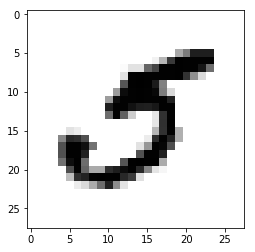

In [19]:
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary) # These are greyscale images. Specified with cmap.
plt.show()

Let's make a smalle function that plots MNIST images:

In [20]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary)
    plt.axis("Off")

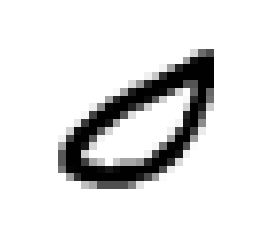

In [21]:
plot_digit(X[1234])

...and plot a random selection:

In [22]:
import random

In [23]:
num=10
to_plot = random.choices(X, k=num)

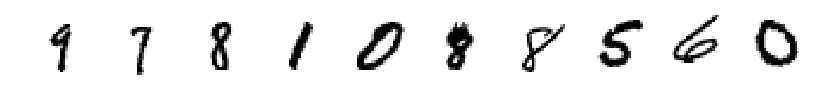

In [24]:
f = plt.figure(figsize=(14,14))
for i in range(num):
    plt.subplot(1,num,i+1)
    plot_digit(to_plot[i])
plt.show()

# Create training and test sets

We use the first 60.000 images as our training data, and the last 10.000 as test (this is the standard division for MNIST).

In [25]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Later we'll want to select subsets of the training data. To increase our chances that each subset contains all the digits we shuffle the data. We can use Numpy's `random.permutation`.

In [26]:
np.random.permutation(5)

array([1, 4, 2, 0, 3])

In [27]:
# Before:
y_train[:5]

array([0., 0., 0., 0., 0.])

In [28]:
np.random.seed(seed=seed)
shuffled_indices = np.random.permutation(len(X_train))
X_train, y_train = X_train[shuffled_indices], y_train[shuffled_indices]

In [29]:
# After:
y_train[:5]

array([1., 6., 6., 1., 1.])

# A binary classifier

We start by constructing a **binary classifier**: a system that aims to distinguish 5's from non-5's. This makes things easier.

In [30]:
y_train_5 = (y_train == 5) # `True` if the label is 5, else `False`
y_test_5 = (y_test == 5)

## Building a model

We have a lot of choices when building our model, something we'll learn more about in Part 3 of the course. For now, let's use `SGDClassifier` as a "black box", without studying how it works behind the scenes (but feel free to read more about the model [here](http://scikit-learn.org/stable/modules/sgd.html)). Our focus is on classification in general, not specific models. 

In [31]:
from sklearn.linear_model import SGDClassifier

In [32]:
# Create an instance of the model:
sgd_clf = SGDClassifier()

In [33]:
# Train the model:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

The model is now trained on the training data, and we can use it to predict whether a digit is a 5 or not:

In [34]:
def predict_image(X):
    plot_digit(X)
    plt.title('Input image')
    plt.show()
    
    # Predict
    pred = sgd_clf.predict([X]) 
    print(f'Prediction: {pred}')

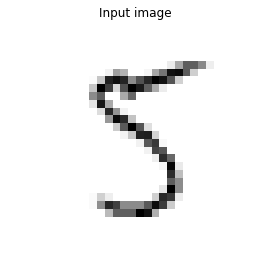

Prediction: [ True]


In [35]:
predict_image(X_test[5300])

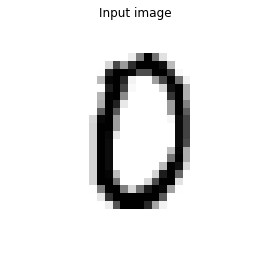

Prediction: [False]


In [36]:
predict_image(X_test[10])

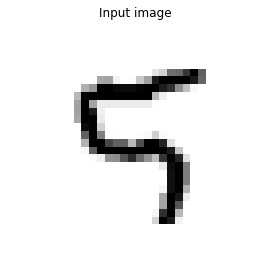

Prediction: [False]


In [37]:
predict_image(X_test[5212])

By experimenting with various input images you'll notice that the model is correct some times, incorrect other. **How good is the model, really?** 

We need ways to evaluate and validate the models we construct.

# Evaluating models. "Performance measures"

First of all, when evaluating the performance of a model one should really ask "what is the end goal for my system"? We're supposed to create systems that are useful in some context, as part of a larger system, which typically has a higher-level goal that our system should aim to optimize. Perhaps it's worth sacrificing accuracy for speed, or not getting a lot of useless clicks that don't lead to sales. 

However, we won't think about these things in the following. 

## Accuracy and different kinds of errors

For classification a common metric is accuracy: what fraction of our predictions were correct? 

But there are different kinds of errors: if we classify something as belonging to the positive class we can either be correct (**true positive**) or incorrect (**false positive**). If we classify something as negative we can either be correct (**true negative**) or incorrect (**false negative**). 

Which kinds of errors we care most about depends on the task: if we're diagnosing a treatable condition in patients we should do everything we can to reduce the false negative rate. While perhaps still keeping an on the false positive rate because a positive diagnosis could lead to invasive and extensive further testing for the patient.

In spam filtering we care most about not marking important emails as spam, i.e. we want a low false positive rate (non-spam marked as spam) even if it means a higher false negative rate (some spam emails ending up in our inbox). 

We'll see how we can measure all these kinds of errors below. But first, we must simulate incoming new, unseen data sets on which to make our measurements. 

### Using a test set

By setting aside a subset of the training data (a hold-out set) as a test set we can use it to evaluate model perfomance. Remember (again!) we're not interested in how well our models perform on the training set, what we're really after is how well they generalize to unseen data. The test set simulates unseen data (and should therefore not be touched when constructing and tuning our models). 

We've seen this idea used earlier in the course, and we know how to do this using the `train_test_split` function.

> **Your turn!**
- Split `(X_train, y_train)` into two parts: one for training, one for evaluation of the model
- Train your model again on the new training set, and compute its accuracy on the test set using the `score` method. 
- Is the result good? What accuracy would a random guesser have?

### Cross-validation

A frequently used way to evaluate models is to do *cross-validation*. A very important advantage of this method over the one above is that it doesn't waste as much training data. Unless you have plenty of data, cross-validation is the preferred method for estimating model performance.

Cross-validation provides a more thorough test than splitting the data into a training set and a test set. The `train_test_split` procedure sets aside a random subset of the data as a test set. If we're "lucky", all the difficult examples end up in the training set, while the test set contains only easy ones. That would lead to an overestimate of the true performance of our model.

The idea is to randomly split the training set into several parts, so called *folds*. Say into K folds, for example. Then train a model K times, each time using a different fold for evaluation and training on the remaining K-1. The average score for the K runs is used to estimate the model's performance. 

This means that *each sample in the training set is part of the training set K-1 times and the evaluation set once*. 

<img src="assets/K-fold_cross_validation_EN.jpg"><br>
<span style="font-size:70%">Image from <a href="https://commons.wikimedia.org/wiki/File:K-fold_cross_validation_EN.jpg">Wikipedia</a></span>

Note: the special case where K is set to the number of data points in the training set is called *leave-one-out*. Each fold is then a single sample.

The result of this K-fold cross validation procedure is an array of K evaluation scores.

In [38]:
from sklearn.model_selection import cross_val_score

In [39]:
cv_scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=5, scoring="accuracy")
print(cv_scores)

[0.95458712 0.96441667 0.94425    0.9665     0.95641303]


In [40]:
cv_scores.mean()

0.9572333637652781

The mean accuracy for our model is roughly 94% &ndash; 96%, which looks pretty good! 

...but is it really? Remember, there are 10 digits in MNIST. A subset of the data is therefore expected to contain roughly 10% 5's and 90% non-5's. We're dealing with a highly **unbalanced dataset** (also called a *skewed dataset*).

A model that's always predicting non-5's will have an accuracy of approximately 90%. That makes our model less impressive...

Luckily, there's a better way to evaluate the model than computing the accuracy!

## Confusion matrix

A confusion matrix us a table summarizing the results from a classification model's predictions. It displays in what way your classifier is "confused": what kind of errors it tends to make. 

The idea is to count the number of times instances of a certain class is classified as the different classes in your problem. In our case, how often a 5 is misclassified as a non-5. 

It's particularly useful when there are more than two classes, as we shall see later. 

We need a set of predictions to compare with the true classes. We can get predicitons using `cross_val_predict`, which works in a similar to `cross_val_score` except that it returns predictions based on all the K folds.

In [41]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

Now we want to compare

In [42]:
y_train_pred

array([False, False, False, ..., False, False, False])

...to

In [43]:
y_train_5

array([False, False, False, ..., False, False, False])

Let's first compute the confusion matrix and then explain what it tells us.

In [44]:
from sklearn.metrics import confusion_matrix

In [45]:
cm = confusion_matrix(y_train_5, y_train_pred)
print(cm)

[[53481  1098]
 [ 1179  4242]]


Here's a convenient function for plotting the confusion matrix. Adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html.

In [46]:
import itertools

In [47]:
def plot_confusion_matrix(cm, classes, ax=None,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, labels=True):
    """
    This function prints and plots the confusion matrix.
    From 
    """
    
    if not ax: fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.setp(ax, xticks=tick_marks, xticklabels=classes, 
             yticks=tick_marks, yticklabels=classes,
             title=title, xlabel="Predicted label", 
             ylabel="True label")
    #ax.set_xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)

    if labels:
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax.text(j, i, format(int(cm[i, j]), fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    return ax

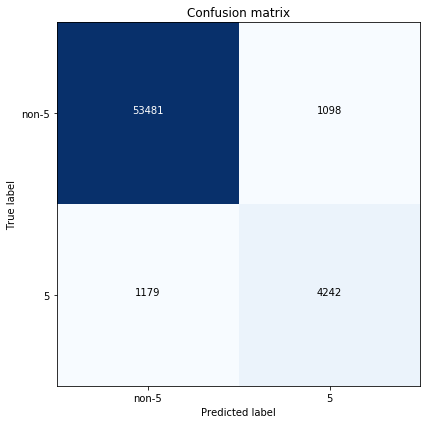

In [48]:
_ = plot_confusion_matrix(cm, classes=['non-5',5])

Each row in the matrix represents a class: non-5s and 5s. Each column represents a predicted class. 

The first row tells us that more than 50.000 images were correctly predicted non-5s (**true negatives**). There were 1000+ images predicted to be 5s but where actually non-5s (**false positives**). 

The second row tells us that around 1500 5's were wrongly labeled (**false negatives**), while the rest of the 5's were correct (**true positives**). 

## Precision and recall

The precision and recall of a classifier are two very useful concepts worth understanding. 

The **precision is the proportion of the positive predictions that were actually correct**. In other words, if we write TP for the true positives and FP for the false positives:

$$\mbox{precision} = \dfrac{TP}{TP+FP}$$

If there are no false positives (which is great!), the precision is 1.0. 

The **recall is the proportion of actual positives that were identified correctly**. In other words, if we write FN for the false negatives, 

$$\mbox{recall} = \dfrac{TP}{TP + FN}$$

If there are no false negatives (which is great!), the recall is 1.0. Recall is very often called *sensitivity*, and sometimes the *true positive rate*.

The connection to the confusion matrix is clear:

<img src="assets/cm_illustration.png"><br>

<span style="font-size:70%"> Image is Figure 3-2 in the textbook</span>

Here's a nice pictorial explanation of precision and recall (from Wikipedia):<br>
<img src="assets/Precisionrecall.svg">

We can compute the precision and recall of our classifier by hand from the confusion matrix (**do that!**), or using scikit-learn:

In [49]:
from sklearn.metrics import precision_score, recall_score

In [50]:
precision_score(y_train_5, y_train_pred)

0.7943820224719101

In [51]:
recall_score(y_train_5, y_train_pred)

0.7825124515771997

We can now see that our classifier isn't particularly good. When predicting that something is a 5 it's only correct approximately 70% of the time. And it only detects about 80% of the 5's. 

## $F_1$ score

To evaluate a classification model you have to consider *both* precision and recall. If you only look at precision you can be fooled by a classifier that makes way too few positive predicitons, but when it does it's typically correct (leading to a very high precision). You also need it to pick up as many of the positive cases as possible (that is, have high recall). The same is true for high recall: it's not enough to detect all the postive examples, the model also has to make correct predictions for them! Otherwise it could just say that "everything is 5!". 

One way to combine precision and recall into one number is to use the **$F_1$ score**, which is a form of average of the two (in fact, what's called the *harmonic mean*):

$$F_1 = \dfrac{2}{\dfrac{1}{\mbox{precision}} + \dfrac{1}{\mbox{recall}}}$$

In [52]:
from sklearn.metrics import f1_score

In [53]:
f1_score(y_train_5, y_train_pred)

0.7884025648173961

An $F_1$ score of 1.0 means perfect precision *and* perfect recall. 

### Precision/recall tradeoff

Unfortunately, very often it's impossible to get *both* high precision and high recall. They are typically competing quantities: when one is high, the other is low. Improving the precision often lowers the recall, and vice-versa. You have to trade one for the other

A classifier with perfect recall is easy to construct: just predict that everything is a 5! Then there are no false negatives and the recall is 1.0. Of course the precision will be rubish. 

To get high precision, just have the classifier predict *one* 5 that it's really sure of, and the rest as non-5s. Then FP will likely be 0 and the precision 1.0. The recall will be really bad since there will be many FNs..

We can see that in action for our `SGDClassifier`. Behind the scenes, when we ran `sgd_clf.fit` on our training data the model finds a *hyperplane*, or a *boundary* in the data space that separates the 5's from the non-5's. 

When feeding `SGDClassifier` and data point it decides whether it is a 5 or a non-5 based on the *distance* from the data point to the hyperplane. By default, if the data point has a negative distance to the plane it's predicted to be from the negative class (a non-5). If it has positive distance it's predicted to be from the positive class (a 5). In other words, the **decision threshold** is set to 0 by default. The distance to the data point can be intepreted as how certain the model is about its prediction. The larger the distance, the more certain. 

But where you set this threshold **makes a big difference!**. We can see that visually here: 

<img src="assets/precisionrecalltradeoff.png">

...and do some experiments with code on our example digit:

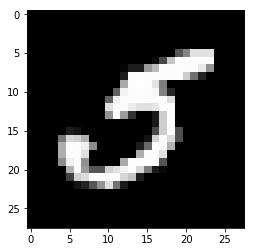

In [54]:
plt.imshow(some_digit.reshape(28,28), cmap="gray")
plt.show()

In [55]:
#sgd_clf has a method that computes the distance of a data point to the hyperplane constructed from the training data:
y_example_score = sgd_clf.decision_function([some_digit])
print(y_example_score)

[-60405.84686182]


In [56]:
threshold = 0
y_example_pred = (y_example_score > threshold)
print(y_example_pred)

[False]


In [57]:
threshold = 30000
y_example_pred = (y_example_score > threshold)
print(y_example_pred)

[False]


You can see that increasing the threshold makes the model less likely to classifiy something as a 5, which increases the precision but lowers the recall. Lowering the threshold makes the recall higher, but lowers the precision. 

Let's plot this!

First we compute the decision function scores for all the training data:

In [58]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5, method='decision_function')

We get 60.000 scores, one for each training example

In [59]:
y_scores.shape

(60000,)

We can compute and plot the precisions and recalls of these for various thresholds:

In [60]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

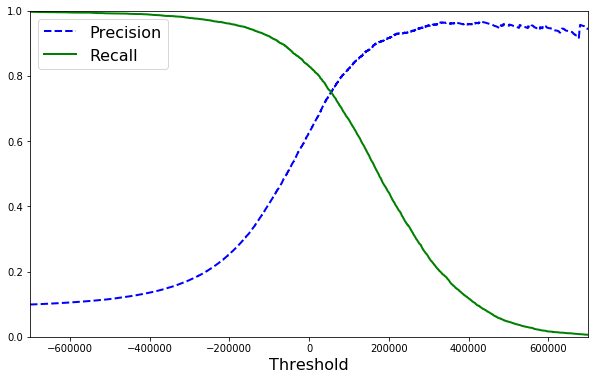

In [61]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(10, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

...and select the threshold value that gives the best precision/recall tradeoff for your task. (**Note:** The choice of threshold should of course be done based on a validation data set, not the test data set! No tweaking of the model based on the test set performance!) 

Are false negatives very bad (like in medical diagnostics)? Use a low threshold to get high recall! Are false positives especially costly? Go for a threshold that gives you high precision!

It's very easy to create a classifier with any precision you want, as long as you don't care about recall. You just have to select a suitable threshold. For example:

In [62]:
y_train_pred_precise = (y_scores > 200000)
precision_score(y_train_5, y_train_pred_precise)

0.9159021406727829

In [63]:
recall_score(y_train_5, y_train_pred_precise)

0.4419848736395499

As Geron writes: 
> If someone says "let's reach 90% precision", you should ask, "at what recall?"

## ROC curves

An **ROC curve (reciever operating characteristic curve)** is a graph that's often used to evaulate binary classifiers (classifiers where there are only two classes). It's a plot of the **true positive rate** (which is another name for recall) versus the **false positive rate**:

$$\begin{align} TPR = \dfrac{TP}{TP + FN}\\ \\ FPR = \dfrac{FP}{FP + TN} \end{align}$$

We compute the TPR and FPR for various thresholds using the `roc_curve` function:

In [64]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

...and plot the ROC curve:

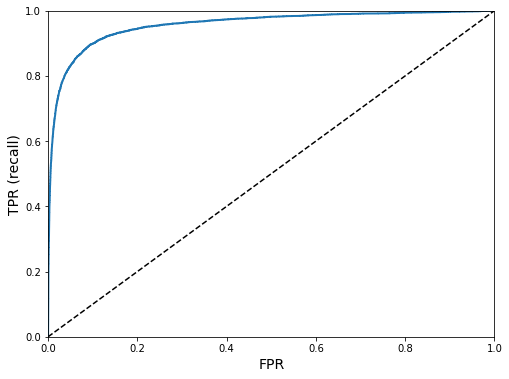

In [65]:
def plot_roc_curve(fpr, tpr, label=None):
    f = plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR', fontsize=14)
    plt.ylabel('TPR (recall)', fontsize=14)
    
plot_roc_curve(fpr, tpr)
plt.show()

A really good classifier will be very close to the top left corner (high TPR and low FPR for any threshold), while a completely random classifier will be close to the dotted line (as many true positives as false positives for any threshold). 

We can use the ROC curve to compute how good the classifier is: if it's really good the area under the curve will be high (i.e. close to the maximum which is 1.0), if it's really bad (i.e random) it will be close to 0.5. 

In [66]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9565495889400213

Is this a good score? Well, not really. There are very few 5's compared to non-5's which means that a classifier that tends to predict 5's too rarely (i.e. low recall) still gets a seemingly okay ROC curve. In cases where you have an imbalanced dataset plotting the precision versus the recall can give you more information:

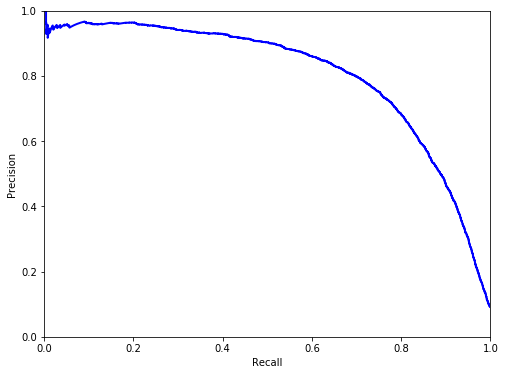

In [67]:
def plot_precision_vs_recall(precisions, recalls):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(recalls, precisions, "b-", linewidth=2)
    plt.setp(ax, xlabel="Recall", ylabel="Precision")
    plt.axis([0, 1, 0, 1])
    return ax
    
_ = plot_precision_vs_recall(precisions, recalls)

What you really want are classifiers whose precisiom-recall curve goes to the far upper right-hand corner. High precision *and* high recall. We notice that in this case we can get a recall of about 0.8 while still having an OK precision. Higher than that the precision drops quickly. 

## Comparing classifiers

Now we have ways to compare classifiers: we can for example use the ROC curve and the ROCAUC (ROC area under the curve). The higer the ROCAUC, the closer the ROC curve comes to the top-left corner. 

We can try out our powers by making another model for our data: a random forest:

In [68]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [69]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

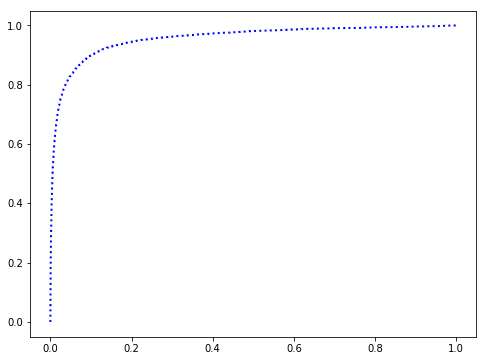

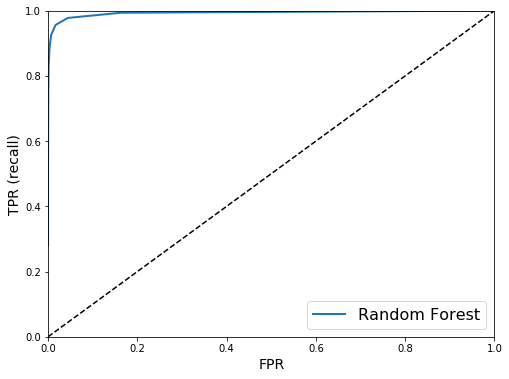

In [70]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

We get that

In [71]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

...which is higher than 

In [72]:
roc_auc_score(y_train_5, y_scores)

0.9565495889400213

...leading us to prefer the random forest model (unless of course other considerations than what's captured by the ROCAUC score are more important to us).

We can also take a look at the two model's precision-recall curves:

In [73]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

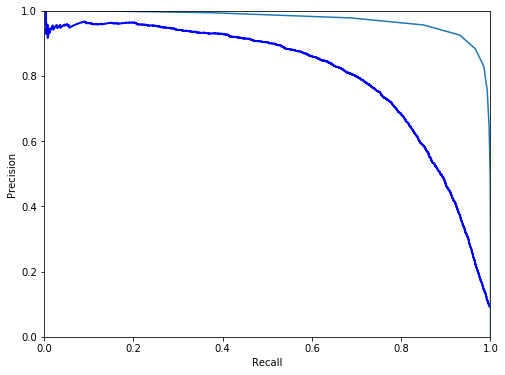

In [74]:
ax = plot_precision_vs_recall(precisions, recalls)
ax.plot(precisions_forest, recalls_forest)
plt.show()

...which also leads us to prefer the random forest (we can get higher precisions at higher recall than for the SGDClassifier).

As for the ROC curve, we can compute the area under the precision-recall curve, also called *average precision* and use this number to assess the model. Often much more convenient than looking at the curve, and it also enables automatic model selection. 

In [76]:
from sklearn.metrics import average_precision_score
aps_sgd = average_precision_score(y_train_5, y_scores)
aps_rf = average_precision_score(y_train_5, y_scores_forest)

In [80]:
print(f'The average precision score of SGDClassifier is: {aps_sgd}\n')
print(f'The average precision score of RF is: {aps_rf}')

The average precision score of SGDClassifier is: 0.8048321238395322

The average precision score of RF is: 0.9655761958824831


# Summary so far

Some of the things we've learned:
- How to train a binary classifier
- Choosing an appropriate metric for the task
- Evalutating classifiers using cross-validation
- Selecting appropriate precision/recall tradeoffs
- Comparing models using ROC curves and ROCAUC scores

# Multi class model: detecting more than 5s

Now that we've seen some of the major tools and concepts in classification, let's try for something harder: predicting all the classes in MNIST. The ideas are all the same, but the difficulty for our model is much higher. 

The performance metrics we use for multi class predictions are derived from the binary classification metrics above, but averaged over all the classes. 

It's easy to use scikit-learn models for multi-class predictions:

In [73]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [74]:
sgd_clf.predict([some_digit])

array([5.])

Scikit-learn trained 10 binary classifiers for us, and used them all on the `some_digit` example. The class whose decision score was highest was outputted by `predict`:

In [75]:
sgd_clf.decision_function([some_digit])

array([[-260626.11840168, -318198.16992436, -326410.18969412,
         -96365.9644322 , -409028.49582465,    3888.84649785,
        -775725.7838696 , -293402.50294538, -653040.3601948 ,
        -597265.7098274 ]])

In [76]:
np.argmax(sgd_clf.decision_function([some_digit]))

5

We can do the same with a random forest classifier:

In [77]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

We can get the list of probabilities that the random forest assigned to each class:

In [78]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

...and notice that the fifth class (corresponding to 5s) got assigned the highest probability.

## Evaluation

As mentioned, we can evaluate the classifiers as before.

### Cross-validation

In [79]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.88042392, 0.86154308, 0.87888183])

In [80]:
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.94041192, 0.93879694, 0.93949092])

### Confusion matrix

Let's compare the two classifiers confusion matrices:

In [81]:
sgd_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
forest_train_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3)

In [82]:
sgd_cm = confusion_matrix(y_train, sgd_train_pred)
forest_cm = confusion_matrix(y_train, forest_train_pred)

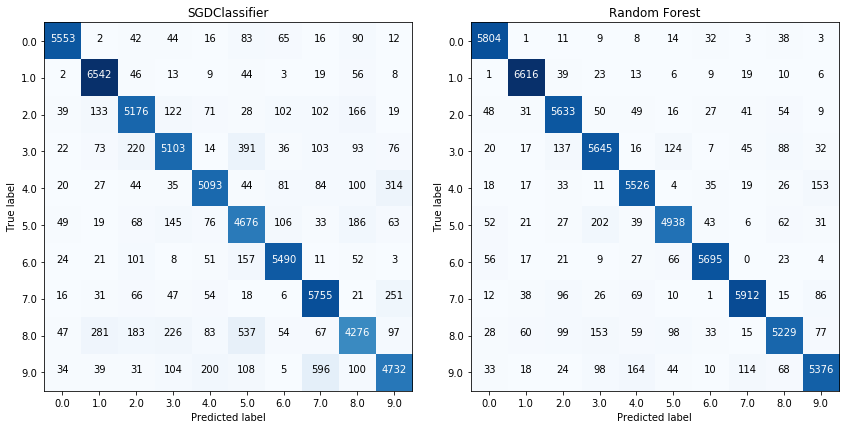

In [83]:
cms = [sgd_cm, forest_cm]
titles = ["SGDClassifier", "Random Forest"]
fig, axes = plt.subplots(1, 2, figsize=(12,6))
for i, ax in enumerate(axes.flat):
    plot_confusion_matrix(cms[i], classes=sgd_clf.classes_, ax=ax, title=titles[i])

Both confusion matrices look pretty good: most of the images are on the diagonal. However, there are errors, and there seems to be some patterns.. Let's take a closer look.

> As a side note: these are not the kinds of models you would use for computer vision problems these days. You may have heard of **"deep learning"** and the **revolution** it has caused in machine learning during the last couple of years. Where it started, and where it's made the most impact until now, is in computer vision. In the last part of the course we'll have a look at deep learning, and study models that can easily reach above 99.7% accuracy on MNIST. Which means that the model makes a mistake on *less than 30 images of the 10.000 test images*! And for some of these images, if we take a look ourself, we would agree with the machine's predictions. Modern deep learning has blown away MNIST as a benchmark by essentially "solving" it. But that's for later...

# Error analysis

We can zoom in on the errors in the confusion matrices by disregarding the dominating main diagonal. 

First we have to scale each value by the number of images in the corresponding class, to properly compare error rates:

In [84]:
row_sums = sgd_cm.sum(axis=1, keepdims=True)
norm_sgd_cm = sgd_cm / row_sums

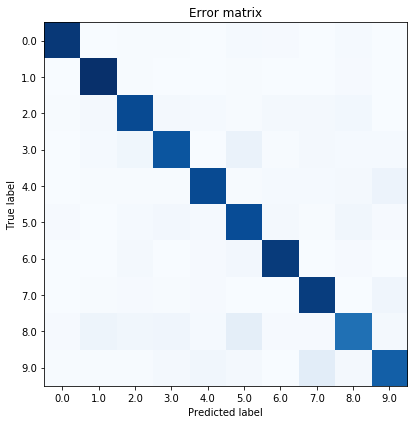

In [85]:
_ = plot_confusion_matrix(norm_sgd_cm, classes=sgd_clf.classes_, title="Error matrix", labels=False)

We notice several intersting things:
- Bright columns for 8 and 9 --> many images get misclassified as 8 or 9s.
- Bright rows for 8 and 9 --> many 8s and 9s are often confused with other digits
- The model confuses for example 7s with 9s and 3s with 5s

Which gives us some ideas for improving our model. E.g. improve the 8 and 9 classifications, and fix the 3/5 confusion.

### Analyzing individual errors

Let's plot some 3s and 5s. Some 3s that the model got correct, some it confused for 5s, some 5s the model confused for 3s and some correct 5s:

In [86]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [87]:
def individual_errors(clf, cl_a, cl_b):
    X_aa = X_train[(y_train == cl_a) & (sgd_train_pred == cl_a)] # Correct class a's
    X_ab = X_train[(y_train == cl_a) & (sgd_train_pred == cl_b)] # a's predicted as b's
    X_ba = X_train[(y_train == cl_b) & (sgd_train_pred == cl_a)] # b's predicted as a's
    X_bb = X_train[(y_train == cl_b) & (sgd_train_pred == cl_b)] # Correct b's
    
    plt.figure(figsize=(10,10))
    plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
    plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
    plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
    plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

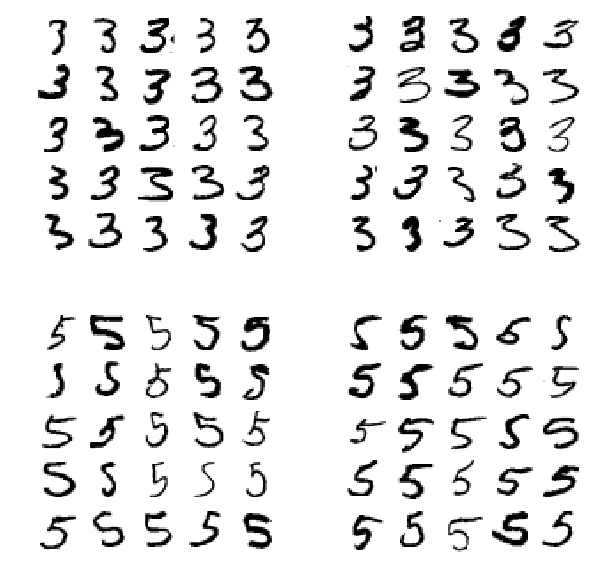

In [88]:
individual_errors(sgd_clf, 3, 5)

The SGDClassifier is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the wighted pixel intensities to get a score for each class. Since 3s and 5s only differ only by a few pixels, this model will easily confuse them. Same for 7s and 9s:

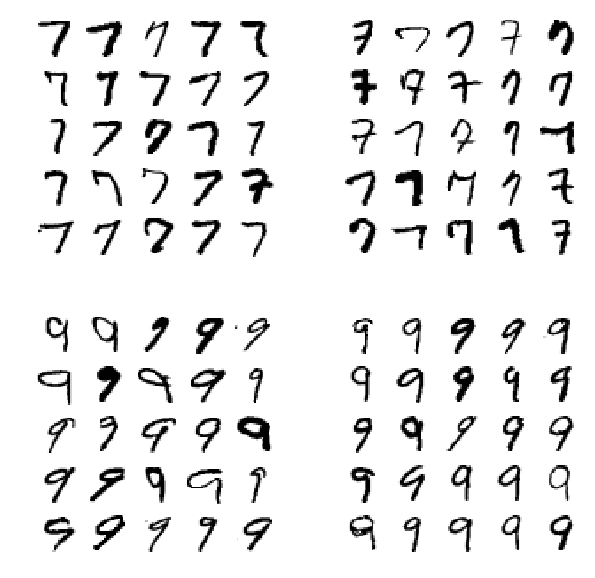

In [89]:
individual_errors(sgd_clf, 7, 9)

One would expect it to perform better on for example 1s and 4s:

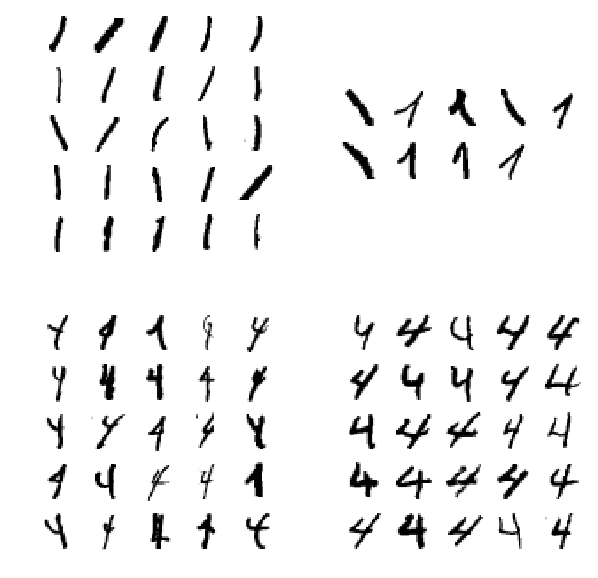

In [90]:
individual_errors(sgd_clf, 1, 4)

# End

Now you've learned about some of the main practical machine learning ideas and techniques, and you're well-equipped to go out and attack real-world problems. 

However, we've treated the models as black boxes. We haven't really discussed **how they work**! It's important to know some of the how's to be an effective machine learning practitioner. 

In Part 3 we'll start to dig deeper. How are the models constructed? How are they trained?

> A *very ambitious* project if you feel up for it: repeat what we did above, but replace the images with skin cancer images from the ISIC archive (https://isic-archive.com/). You can find a convenient copy of the data here: https://challenge2018.isic-archive.com/. I recommend simplifying to a "benign" versus "abnormal" prediction task by reducing the number of categories in the data set to two. 

> The most difficult part of this problem is to get the data in a form in which you can feed it to machine learning models. Once that's done, to get a model that's not completely horrible you'll have to do some data preprocessing (like scaling the images and the pixel values). And also use a powerful model with well-tuned hyperparameters. Still you won't score very well. Unless you use deep learning.... See https://www.nature.com/articles/nature21056. 